## Anomaly Detection- windowed method 

In [1]:
import numpy as np
import pickle
import pandas as pd
from datetime import datetime
import keras
from keras import layers
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout
from utils.functions import sample, create_sequences, get_error_term
from model.vae_window import vae_window

Importing the dataset

In [2]:
data = pd.read_csv("data/realKnownCause/realKnownCause/nyc_taxi.csv",
                   parse_dates=True, index_col="timestamp")
data

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309


In [3]:
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)

# Access the lists
instances_of_anomaly= lists[2]

In [4]:
data_with_anomaly = data.copy()
data_with_anomaly['anomaly'] = 0
for instance in instances_of_anomaly: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data_with_anomaly.loc[(data_with_anomaly.index >= start) & (data_with_anomaly.index <= end), 'anomaly'] = 1

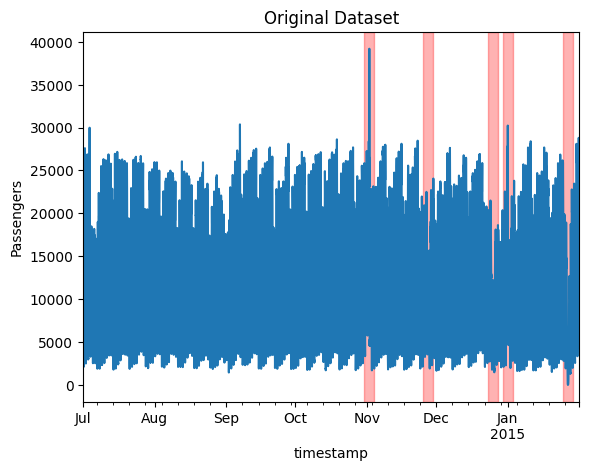

In [5]:
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
plt.ylabel("Passengers")
plt.title("Original Dataset")
plt.show()

Splitting training and testing

In [6]:
# Splitting to train and test
train_ratio = 0.5
test_ratio = 0.2
tr_data = data.iloc[0: int(len(data) * train_ratio)]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]
data_with_anomaly= data_with_anomaly.iloc[int(len(data) * (1 - test_ratio)) :]

In [7]:
tr_data

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2014-10-16 09:30:00,20452
2014-10-16 10:00:00,19678
2014-10-16 10:30:00,18801


Normailzing the training set 

In [8]:
# Normalize and save the mean and std we get, for normalizing test data.
training_mean = tr_data.mean()
training_std = tr_data.std()
train_scaled = (tr_data - training_mean) / training_std
print("Number of training samples:", len(train_scaled))

Number of training samples: 5160


Function to create the windowed data

Each sample is half an hour apart, so 336 samples accounts for a week

In [9]:
step_size = 336

train = create_sequences(train_scaled.values, step_size)
print("Training input shape: ", train.shape)

Training input shape:  (4825, 336, 1)


VAE model

In [10]:
vae = vae_window(train, latent_dim=8)
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 336, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 168, 32)   │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 168, 32)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 84, 16)    │      3,600 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 8),       │     25,376 │ input_layer[0][0] │
│ (Functional)        │ (None, 8), (None, │            │                   │
│                     │ 8)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1344)      │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 336, 1)    │     66,465 │ encoder[0][2]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │     10,760 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │     10,760 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 336, 1)    │          0 │ input_layer[0][0… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,841 (358.75 KB)

 Trainable params: 91,841 (358.75 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = vae.fit(
    train,
    train,
    epochs=1000,
    batch_size=256,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])

Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 81981.6016 - val_loss: 56573.6836
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 41308.5352 - val_loss: 31675.5469
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 29308.9277 - val_loss: 27303.2129
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 25607.1777 - val_loss: 20349.9043
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 18526.4590 - val_loss: 13950.2578
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 13639.9795 - val_loss: 10903.2158
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 10983.0020 - val_loss: 9387.9678
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9371.2715 - val_loss: 7959.2686
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8090.6504 - val_loss: 7055.2773
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7224.0308 - val_loss: 6199.3711
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - 

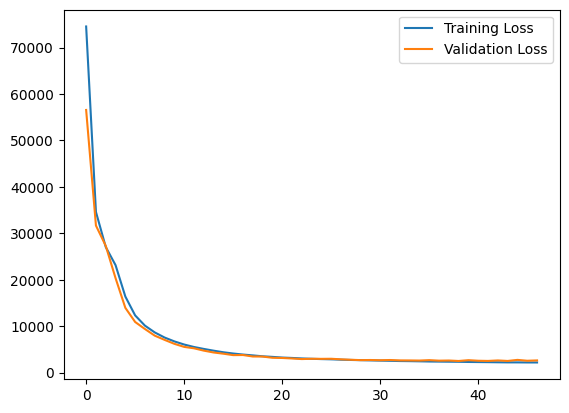

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(4825, 1)


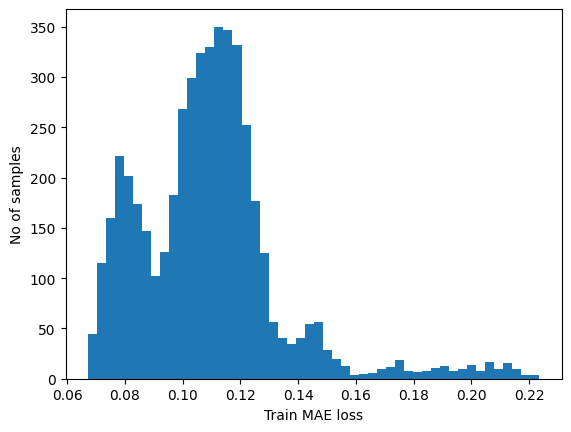

Reconstruction error threshold:  0.22346853995908614


In [13]:
# Get train MAE loss.
train_pred = vae.predict(train)[0]
train_mae_loss = np.mean(np.abs(train_pred - train), axis=1)
print(train_mae_loss.shape)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [14]:
print(train_pred.shape)

(4825, 336, 1)


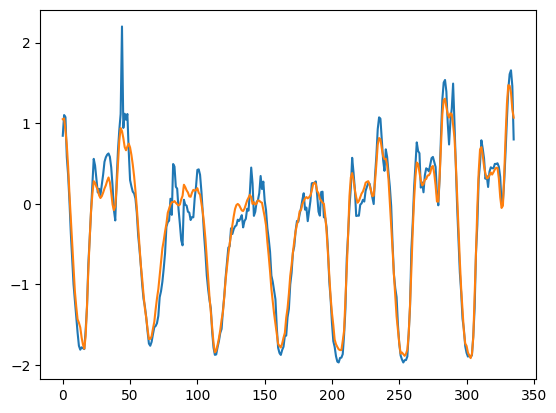

In [15]:
# Checking how the first sequence is learnt
plt.plot(train[90])
plt.plot(train_pred[90])
plt.show()

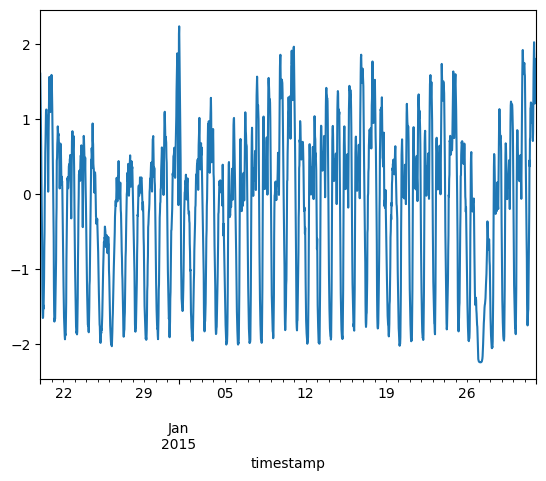

Test input shape:  (1729, 336, 1)
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(1729, 1)


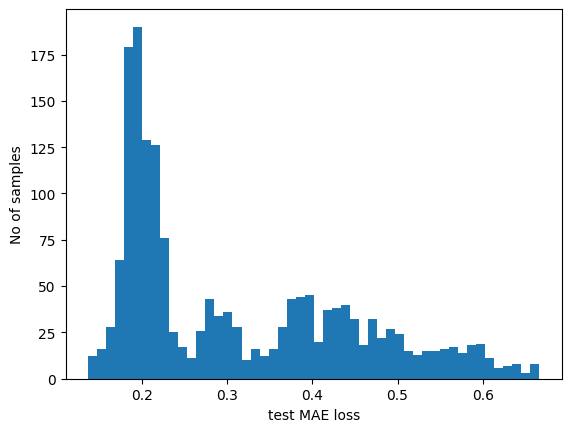

Number of anomaly samples:  416
Indices of anomaly samples:  (array([   0,    1,    2,   33,   34,  337,  338,  339,  340,  341,  342,
        343,  344,  345,  346,  364,  365,  366,  367,  368,  369,  374,
        404,  405,  406,  407,  408,  409,  410,  411,  412,  413,  414,
        415,  416,  417,  418,  419,  420,  421,  422,  423,  424,  425,
        426,  427,  428,  429,  430,  431,  432,  433,  434,  435,  436,
        437,  438,  439,  440,  441,  442,  443,  444,  448,  449,  450,
        451,  452,  453,  454,  455,  456,  457,  458,  461,  462,  463,
        464,  465,  466,  467,  468,  469,  470,  471,  472,  473,  474,
        475,  476,  477,  478,  479,  480,  481,  482,  483,  484,  485,
        486,  487,  488,  489,  490,  491,  492,  493,  494,  495,  496,
        497,  498,  499,  500,  501,  502,  503,  504,  505,  506,  507,
        508,  509,  510,  511,  512,  513,  514,  515,  516,  517,  518,
        519,  520,  521,  522,  523,  524,  525,  526,  527,  

In [23]:

test_scaled = (tst_data - training_mean) / training_std
fig, ax = plt.subplots()
test_scaled.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
test = create_sequences(test_scaled.values, step_size)
print("Test input shape: ", test.shape)

# Get test MAE loss.
test_pred = vae.predict(test)[0]
test_mae_loss = np.mean(np.abs(test_pred - test), axis=1)
print(test_mae_loss.shape)
#test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [24]:
anomalous_data_indices = []
for ind in range(len(anomalies)):
    if anomalies[ind]:
        anomalous_data_indices.append(ind)

In [25]:
# # data i is an anomaly if more than 90% of samples [(i - timesteps + 1) to (i)] are anomalies
# anomalous_data_indices = []
# for data_idx in range(step_size - 1, len(test_scaled) - step_size + 1):
#     if np.sum(anomalies[data_idx - step_size + 1 : data_idx]) > step_size * 0.9:
#         anomalous_data_indices.append(data_idx)

In [26]:
print("Indices of anomalies: ", anomalous_data_indices)

Indices of anomalies:  [0, 1, 2, 33, 34, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 364, 365, 366, 367, 368, 369, 374, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 572, 573, 574, 575, 576, 577, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507,

In [27]:
df_subset = tst_data.iloc[anomalous_data_indices]
df_subset

,value
timestamp,
2014-12-20 00:00:00,25976
2014-12-20 00:30:00,24322
2014-12-20 01:00:00,22993
2014-12-20 16:30:00,15360
2014-12-20 17:00:00,17470
...,...
2015-01-24 22:00:00,24357
2015-01-24 22:30:00,25009
2015-01-24 23:00:00,25641


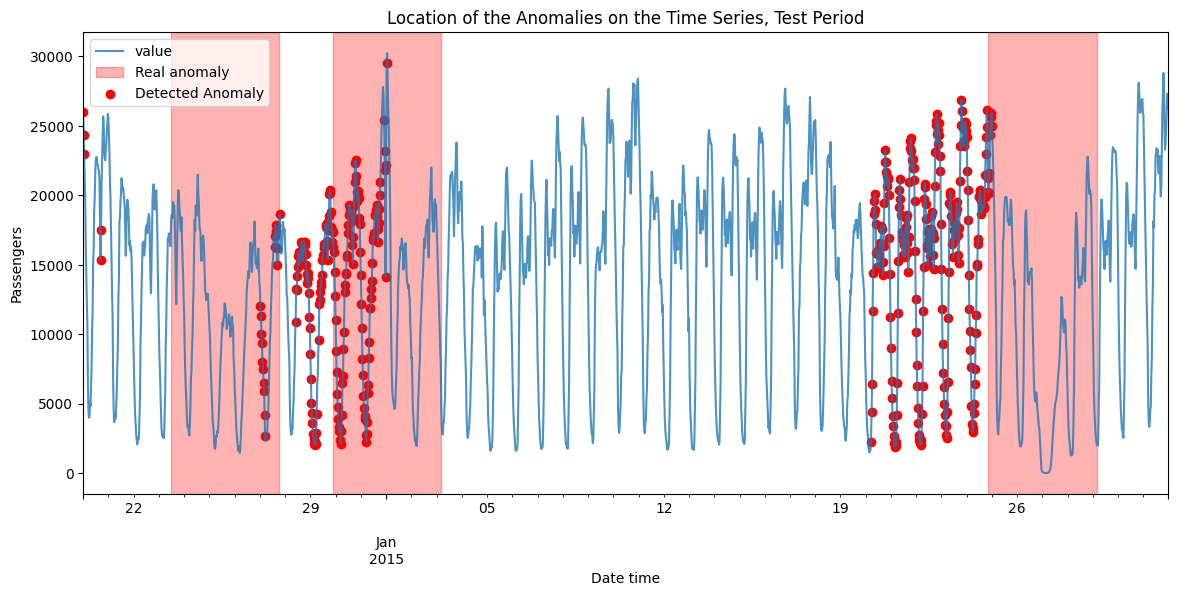

In [32]:
fig, ax = plt.subplots(figsize=(14, 6))
tst_data.plot(legend=False, ax=ax, alpha=0.8)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
ax.scatter(df_subset.index, df_subset['value'], color="r", label="Detected Anomaly")
plt.legend()
plt.xlabel('Date time')
plt.ylabel('Passengers')
plt.title("Location of the Anomalies on the Time Series, Test Period")
plt.show()

In [29]:
from utils.scoring import score_fn
anomaly_ranges = [(datetime.strptime(start, "%Y-%m-%d %H:%M:%S.%f"), 
                       datetime.strptime(end, "%Y-%m-%d %H:%M:%S.%f")) for start, end in instances_of_anomaly[2:]]
res= score_fn(list(df_subset.index), anomaly_ranges)
print (res)
print (f'Score: {np.sum(res)}')

[-0.11, -0.11, -0.11, -0.11, -0.11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.001334885922682786, -0.03953561487788598, -0.04069301356157745, -0.04184006686876443, -0.04297657959066759, -0.044102366240623365, -0.045217251074238754, -0.04632106809300774, -0.0474136610318208, -0.04849488333083564, -0.049564598092209505, -0.050622678022224095, -0.05166900535936022, -0.052703471788903444, -0.05372597834468183, -0.054736435298554896, -0.05573476203828656, -0.056720886934446595, -0.05769474719699339, -0.05865628872219641, -0.05960546593055963, -0.060542241596407545, -0.061466586669793315, -0.06237848009138425, -0.06327790860097236, -0.06416486654025047, -0.06503935565048213, -0.06590138486568246, -0.0667509701019121, -0.06758813404327171, -0.06841290592516734, -0.0692253213153987, -0.0700254218936041, -0.07081325522957556, -0.07158887456093645, -0.07235233857065404, -0.07310371116483619, -0.07384306125124036, -0.0745704625189001, -0.07528599321925185, -0.07598973594912266, -0.076681